In [1]:
import requests
import json
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from pynvml import *
import psutil
import os

C:\Users\HP\AppData\Local\Temp\ipykernel_12748\2238081627.py:16: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  from pynvml import *


In [2]:
try:
    df = pd.read_csv("../test_llm.csv")
except FileNotFoundError:
    print("Error: File 'test_llm.csv' not found.")
    print("Pastikan file tersebut berada di direktori yang sama dengan script ini.")
    exit()

In [3]:
test_df = df.copy()
test_df['label_score'] = test_df['Emotion']

In [4]:
import os
import time
import json
import pandas as pd
from dotenv import load_dotenv, find_dotenv
import psutil
from openai import OpenAI

# =======================================================
# = LOAD API KEY
# =======================================================
dotenv_path = find_dotenv(usecwd=True, raise_error_if_not_found=False)
if dotenv_path:
    load_dotenv(dotenv_path)
else:
    print("⚠️ .env tidak ditemukan.")

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# =======================================================
# = RAM MONITOR
# =======================================================
def get_ram_usage_gb():
    return psutil.virtual_memory().used / (1024**3)

def get_vram_usage_gb():
    return 0.0  # Model cloud → VRAM 0

# =======================================================
# = PARAMETER
# =======================================================
emotion_labels = ["Anger", "Fear", "Happy", "Love", "Sadness"]
predictions = []
start_time = time.time()
PENDING_TIMEOUT = 2

model_name = "ft:gpt-4.1-nano-2025-04-14:personal:emotion-classification-indonesian-e-commerce:Cpu8GHwK"

print(f"🚀 Mulai inferensi dengan model: {model_name}")
print("-" * 50)

# =======================================================
# = LOOP INFERENSI
# =======================================================
for i, row in test_df.iterrows():
    teks = row["Customer Review"]

    # SYSTEM PROMPT
    system_prompt = (
    "Kamu adalah model klasifikasi emosi ulasan e-commerce."
    )

    user_prompt = f"""
    {teks}
    """

    t0 = time.time()

    try:
        # ============================
        # REQUEST OPENAI API
        # ============================
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt},
            ],
            temperature=0
        )

        # Extract usage metadata
        usage = response.usage
        input_tokens = usage.prompt_tokens if usage else 0
        output_tokens = usage.completion_tokens if usage else 0

        # Parse JSON response
        assistant_text = response.choices[0].message.content.strip()
        emosi_pred = assistant_text.capitalize()

        # Metrics
        latency = time.time() - t0
        ram_usage = get_ram_usage_gb()
        vram_usage = get_vram_usage_gb()

        predictions.append({
            "text": teks,
            "actual": row["Emotion"],
            "predicted": emosi_pred,
            "latency_sec": latency,
            "ram_gb": ram_usage,
            "vram_gb": vram_usage,
            "prompt_tokens": input_tokens,
            "completion_tokens": output_tokens,
        })

        print(f"[{i}] {teks[:50]} → {emosi_pred} | {latency:.2f}s | Tokens: {input_tokens}/{output_tokens}")

        # Delay 10 detik
        print(f"[{i}] 💤 Menunggu {PENDING_TIMEOUT} detik...")
        time.sleep(PENDING_TIMEOUT)

    except Exception as e:
        print(f"[{i}] ❌ Error API OpenAI: {e}")
        continue

# =======================================================
# = RINGKASAN
# =======================================================
end_time = time.time()
total_time = end_time - start_time

if predictions:
    latencies = [p["latency_sec"] for p in predictions]
    lat_no_first = latencies[1:] if len(latencies) > 1 else latencies
    avg_latency = sum(lat_no_first)/len(lat_no_first) if lat_no_first else 0
    throughput = (len(lat_no_first)/sum(lat_no_first))*60 if len(lat_no_first)>1 else 0

    avg_prompt_tokens = sum(p["prompt_tokens"] for p in predictions)/len(predictions)
    avg_completion_tokens = sum(p["completion_tokens"] for p in predictions)/len(predictions)

    avg_ram = sum(p["ram_gb"] for p in predictions)/len(predictions)
    avg_vram = sum(p["vram_gb"] for p in predictions)/len(predictions)

    print("\n" + "="*50)
    print("📊 RINGKASAN EVALUASI")
    print("="*50)
    print(f"Total sampel   : {len(predictions)}")
    print(f"Total waktu    : {total_time:.2f} detik")
    print(f"Avg latency    : {avg_latency:.2f} detik")
    print(f"Throughput     : {throughput:.2f} sampel/menit")
    print("-"*50)
    print(f"Rata2 Prompt Tokens     : {avg_prompt_tokens:.0f}")
    print(f"Rata2 Completion Tokens : {avg_completion_tokens:.0f}")
    print("-"*50)
    print(f"Rata2 RAM usage : {avg_ram:.2f} GB")

    # Simpan CSV
    results_df = pd.DataFrame(predictions)
    results_df.to_csv("results_metrics_emotion_openai.csv", index=False)
    print("✅ Disimpan ke: results_metrics_emotion_openai.csv")

else:
    print("❌ Tidak ada prediksi yang berhasil.")

🚀 Mulai inferensi dengan model: ft:gpt-4.1-nano-2025-04-14:personal:emotion-classification-indonesian-e-commerce:Cpu8GHwK
--------------------------------------------------
[0] buahnya bagus... kurirnya ok sellernya juga ok → Happy | 1.22s | Tokens: 41/1
[0] 💤 Menunggu 2 detik...
[1] Ada sedikit cacat, selainnya oke → Happy | 0.40s | Tokens: 36/1
[1] 💤 Menunggu 2 detik...
[2] Jadi semangat mancing. → Happy | 0.40s | Tokens: 33/1
[2] 💤 Menunggu 2 detik...
[3] Cepat tiba n kemasan bagus. barangnya juga bagus → Happy | 0.90s | Tokens: 40/1
[3] 💤 Menunggu 2 detik...
[4] Produk sesuai deskripsi??. Variasi produk beragam. → Happy | 0.50s | Tokens: 44/1
[4] 💤 Menunggu 2 detik...
[5] pelayanan memuaskan dan barang sesuai ?? → Happy | 0.51s | Tokens: 35/1
[5] 💤 Menunggu 2 detik...
[6] Barang bagus dan cepat sekali sampainya ke cianjur → Happy | 0.66s | Tokens: 47/1
[6] 💤 Menunggu 2 detik...
[7] Bagus mantab jernih → Happy | 0.88s | Tokens: 35/1
[7] 💤 Menunggu 2 detik...
[8] trmksh barang sesuai

In [5]:
results_df = pd.read_csv('results_metrics_emotion_openai.csv')

In [6]:
import pandas as pd

# Load data
df = pd.read_csv("results_metrics_emotion_openai.csv")

# Ambil latency per sampel (detik)
latencies = df["latency_sec"].values

# Jumlah sampel
N = len(latencies)

# ------------------------
# LATENCY (Persamaan 5)
# ------------------------
avg_latency = latencies.sum() / N  # detik per sampel

# ------------------------
# THROUGHPUT (Persamaan 6)
# ------------------------
T_seconds = latencies.sum()        # total waktu pemrosesan (detik)
throughput_per_minute = (N / T_seconds) * 60

print(f"Jumlah sampel (N): {N}")
print(f"Rata-rata latency (s/sample): {avg_latency:.2f}")
print(f"Throughput (sample/minute): {throughput_per_minute:.2f}")


Jumlah sampel (N): 225
Rata-rata latency (s/sample): 0.52
Throughput (sample/minute): 115.91


In [7]:
y_true = results_df["actual"]
y_pred = results_df["predicted"]

In [8]:
y_true = pd.Series(y_true)
y_pred = pd.Series(y_pred)

print("y_true unique:", y_true.unique())
print("y_pred unique:", y_pred.unique())

print("NaN y_true:", y_true.isna().sum())
print("NaN y_pred:", y_pred.isna().sum())

y_true unique: ['Happy' 'Sadness' 'Fear' 'Love' 'Anger']
y_pred unique: ['Happy' 'Love' 'Sadness' 'Fear' 'Anger']
NaN y_true: 0
NaN y_pred: 0


In [9]:
report = classification_report(y_true, y_pred, digits=2, zero_division=0)
print("\n=== CLASSIFICATION REPORT ===")
print(report)


=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

       Anger       0.87      0.73      0.80        45
        Fear       0.89      0.71      0.79        45
       Happy       0.83      0.87      0.85        45
        Love       0.86      0.82      0.84        45
     Sadness       0.69      0.93      0.79        45

    accuracy                           0.81       225
   macro avg       0.83      0.81      0.81       225
weighted avg       0.83      0.81      0.81       225



In [10]:
accuracy = accuracy_score(y_true, y_pred)
precision_avg = precision_score(y_true, y_pred, average="macro", zero_division=0)
recall_avg = recall_score(y_true, y_pred, average="macro", zero_division=0)
f1_avg = f1_score(y_true, y_pred, average="macro", zero_division=0)

In [11]:
print(f"Precision avg : {precision_avg:.2f}")
print(f"Recall avg : {recall_avg:.2f}")
print(f"F1 avg : {f1_avg:.2f}")
print(f"Akurasi : {accuracy:.2f}")

Precision avg : 0.83
Recall avg : 0.81
F1 avg : 0.81
Akurasi : 0.81


✅ Confusion matrix disimpan di 'confusion_matrix_emotion_llm.png'


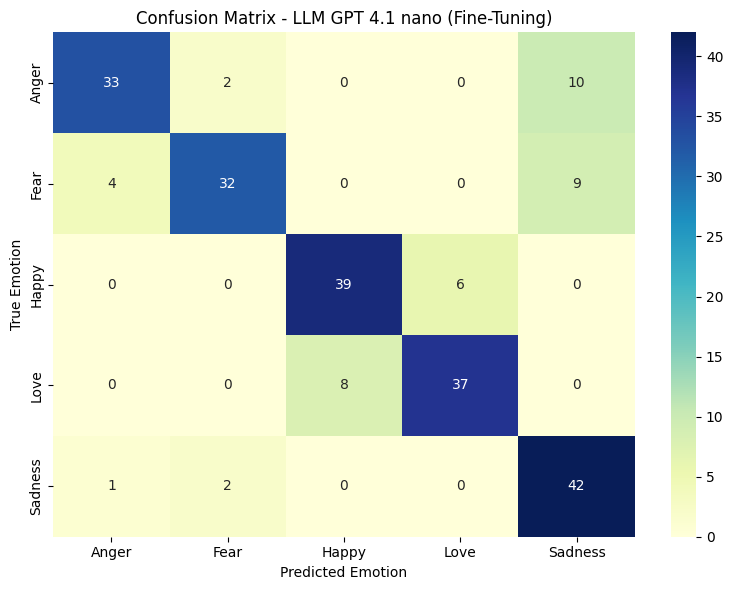

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# === Buat confusion matrix ===
cm = confusion_matrix(y_true, y_pred, labels=['Anger', 'Fear', 'Happy', 'Love', 'Sadness'])

# === Plot heatmap ===
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=['Anger', 'Fear', 'Happy', 'Love', 'Sadness'],
            yticklabels=['Anger', 'Fear', 'Happy', 'Love', 'Sadness'])

plt.title("Confusion Matrix - LLM GPT 4.1 nano (Fine-Tuning)")
plt.xlabel("Predicted Emotion")
plt.ylabel("True Emotion")
plt.tight_layout()
plt.savefig("confusion_matrix_emotion_llm.png", dpi=300)
print("✅ Confusion matrix disimpan di 'confusion_matrix_emotion_llm.png'")
plt.show()